## Binary classification with DeepCNN

The paths utilized are defiend in the `path_module.py`

Before this, the data must be processed. 
- `data_processing` notebook loads raw data and prepares training,validation and test dataset

### 1. Import libraries

In [1]:
from modules.path_module import *
from modules.utils_module import *
import os
import joblib
import torch
import numpy as np
import matplotlib.pyplot as plt

### 2. Load data

In [2]:
train_data=joblib.load(os.path.join(processed_datapath,"train_data.joblib"))
test_data=joblib.load(os.path.join(processed_datapath,"test_data.joblib"))
val_data=joblib.load(os.path.join(processed_datapath,"val_data.joblib"))

### 3. Prepare data 
- We train using the training set and save the model that gives the best performance on the validation set

In [3]:
train_sigdata,train_label=prepare_cnn_data(train_data)
val_sigdata,val_label=prepare_cnn_data(val_data)
test_sigdata,test_label=prepare_cnn_data(test_data)

### 4. DeepCNN model

Paper: https://link.springer.com/article/10.1007/s00521-018-3689-5

Architecture: https://link.springer.com/article/10.1007/s00521-018-3689-5/tables/1

| Layers | Layer name    | Kernel size | No. of filters | Stride | Output shape | No. of trainable parameters | Regularization  |
|--------|---------------|-------------|----------------|--------|--------------|-----------------------------|-----------------|
| 0      | Input         | –           | –              | –      | 2500 x 59    | 0                           | –               |
| 1      | 1D convolution| 20 x 1      | 5              | 1      | 2481 x 5     | 6000                        | –               |
| 2      | Max-pooling   | 2 x 1       | 5              | 2      | 1240 x 5     | 0                           | –               |
| 3      | 1D convolution| 10 x 1      | 10             | 1      | 1231 x 10    | 5000                        | –               |
| 4      | Max-pooling   | 2 x 1       | 10             | 2      | 615 x 10     | 0                           | –               |
| 5      | 1D convolution| 10 x 1      | 10             | 1      | 606 x 10     | 10000                       | –               |
| 6      | Max-pooling   | 2 x 1       | 10             | 2      | 303 x 10     | 0                           | –               |
| 7      | 1D convolution| 5 x 1       | 15             | 1      | 299 x 15     | 7500                        | –               |
| 8      | Max-pooling   | 2 x 1       | 15             | 2      | 149 x 15     | 0                           | –               |
| 10     | Dense         | –           | –              | –      | 20           | 44800                       | Dropout (0.5)   |
| 12     | Dense         | –           | –              | –      | 10           | 210                         | Dropout (0.5)   |
| 13     | Dense         | –           | –              | –      | 2            | 22                          | –               |
|        | Total         |             |                |        |              | 68332                       |                 |


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class CNN_Model(nn.Module):
    def __init__(self,chan_total,signal_length):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=chan_total, out_channels=5, kernel_size=20, stride=1,padding=0)
        self.pool = nn.AvgPool1d(kernel_size=2)
        self.conv2=nn.Conv1d(in_channels=5, out_channels=10, kernel_size=10, stride=1,padding=0)
        self.conv3=nn.Conv1d(in_channels=10, out_channels=10, kernel_size=10, stride=1,padding=0)
        self.conv4=nn.Conv1d(in_channels=10, out_channels=15, kernel_size=5, stride=1,padding=0)
        self.fc1 = nn.Linear(int(149*15), 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 2)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.conv1(x)) # layer 1
        x = self.pool(x) # layer 2
        x=F.relu(self.conv2(x)) # layer 3
        x = self.pool(x) # layer 4
        x=F.relu(self.conv3(x)) # layer 5
        x = self.pool(x) # layer 6
        x=F.relu(self.conv4(x)) # layer 7
        x = self.pool(x) # layer 8
        x = x.view(-1, int(149*15)) 
        x = self.dropout(x) # layer 9
        x=self.fc1(x) # layer 10
        x = self.dropout(x) # layer 11
        x=self.fc2(x) # layer 12
        x=self.fc3(x) # layer 13
        return x

### 5. Initialize model

In [5]:
import torch.optim as optim
from torch import cuda

# Set the random seed for reproducibility
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

# use GPU
device='cpu'#'cuda' if cuda.is_available() else 'cpu'
print("Running on: "+device)
cuda.empty_cache()

# initialize model
n_chan=train_data[0].data.shape[1]
n_datalength=train_data[0].data.shape[0]
model = CNN_Model(n_chan,n_datalength)
model.to(device)
print('Model created')

Running on: cpu
Model created


### 6. Configure Training

In [6]:
batch_size = 16#1 # could not find
#num_epochs = 64
num_epochs = 70 # from paper
lrate=1e-4 #from paper
patience=80 # no early stopping from paper
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lrate)
cnn_modelfullpath=os.path.join(cnn_modelpath,'cnn.pt')

training_arg={
    'modelfullpath': cnn_modelfullpath,
    'criterion': criterion,
    'optimizer': optimizer,
    'epochs': num_epochs,
    'patience': patience,
    'seed': random_seed
}

### 7. Prepare data

In [7]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.stack(train_sigdata), torch.stack(train_label))
val_dataset = TensorDataset(torch.stack(val_sigdata), torch.stack(val_label))
test_dataset = TensorDataset(torch.stack(test_sigdata), torch.stack(test_label))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### 8. Train model

In [8]:
results= model_trainer(model,train_loader,val_loader,training_arg)

Epoch 1/70: 100%|██████████| 21/21 [00:02<00:00,  8.89it/s]


model state saved with validation accuracy: 51.4493


Epoch 2/70: 100%|██████████| 21/21 [00:00<00:00, 27.95it/s]


model state saved with validation accuracy: 56.5217


Epoch 4/70: 100%|██████████| 21/21 [00:00<00:00, 26.50it/s]


model state saved with validation accuracy: 58.6957


Epoch 16/70: 100%|██████████| 21/21 [00:00<00:00, 30.59it/s]


model state saved with validation accuracy: 59.4203


Epoch 18/70: 100%|██████████| 21/21 [00:00<00:00, 30.28it/s]


model state saved with validation accuracy: 60.1449


Epoch 28/70: 100%|██████████| 21/21 [00:00<00:00, 31.02it/s]


model state saved with validation accuracy: 61.5942


Epoch 33/70: 100%|██████████| 21/21 [00:00<00:00, 31.30it/s]


model state saved with validation accuracy: 66.6667


Epoch 65/70: 100%|██████████| 21/21 [00:00<00:00, 34.93it/s]


model state saved with validation accuracy: 68.1159


Epoch 70/70: 100%|██████████| 21/21 [00:00<00:00, 34.73it/s]


### 9. Inspect training process

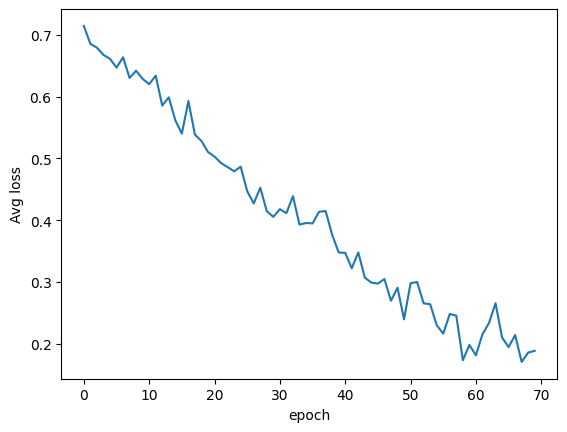

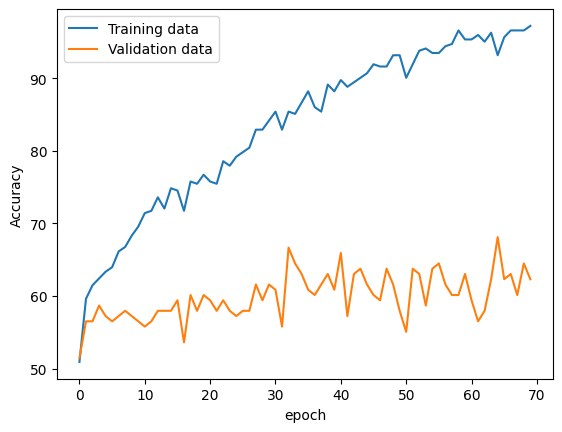

In [11]:
plt.figure()
plt.plot(results['epoch_loss'])
plt.xlabel('epoch')
plt.ylabel('Avg loss')
plt.show()


plt.figure()
plt.plot(results['training_acc'],label='Training data')
plt.plot(results['validation_acc'],label='Validation data')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

### 10. Evaluate model

In [8]:
best_model_state=torch.load(cnn_modelfullpath, map_location=device)
model.load_state_dict(best_model_state,strict=True)
model.eval()
print('Fine tune model loaded')

tr_accuracy, tr_est,tr_labels,tr_scores= evaluate_binary_accuracy(model, train_loader)
print(f'Train Binary Accuracy: {tr_accuracy:.4f}')
perf_metrics(tr_labels, tr_est,tr_scores)
print('\n')
v_accuracy,val_est,val_labels, val_scores = evaluate_binary_accuracy(model, val_loader)
print(f'Validation Binary Accuracy: {v_accuracy:.4f}')
perf_metrics(val_labels, val_est,val_scores)
print('\n')
test_accuracy,test_est,test_labels, test_scores = evaluate_binary_accuracy(model, test_loader)
print(f'Test Binary Accuracy: {test_accuracy:.4f}')
perf_metrics(test_labels, test_est,test_scores)

print('Completed')

Fine tune model loaded
Train Binary Accuracy: 93.1677
Confusion Matrix:
[[168   0]
 [ 22 132]]
Accuracy: 93.16770186335404
Precision: 100.0
Sensitivity (Recall): 85.71428571428571
Specificity: 100.0
F1 Score: 0.923076923076923
AUC Score: 0.9969465058750774


Validation Binary Accuracy: 68.1159
Confusion Matrix:
[[62 10]
 [34 32]]
Accuracy: 68.11594202898551
Precision: 76.19047619047619
Sensitivity (Recall): 48.484848484848484
Specificity: 86.11111111111111
F1 Score: 0.5925925925925926
AUC Score: 0.6616161616161615


Test Binary Accuracy: 58.6957
Confusion Matrix:
[[36 12]
 [26 18]]
Accuracy: 58.69565217391305
Precision: 60.0
Sensitivity (Recall): 40.909090909090914
Specificity: 75.0
F1 Score: 0.4864864864864865
AUC Score: 0.6287878787878788
Completed


### Model Details

In [6]:
from torchsummary import summary

model_params = sum(p.numel() for p in model.parameters())
print(f'Model param total: {model_params}')
print(model)

dummy_input = torch.randn(1, 59, 2500)  # Batch size of 1
output = model(dummy_input)
print(f"Output shape: {output.shape}")

summary(model, input_size=(59, 2500), device=device)

Model param total: 53142
CNN_Model(
  (conv1): Conv1d(59, 5, kernel_size=(20,), stride=(1,))
  (pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv2): Conv1d(5, 10, kernel_size=(10,), stride=(1,))
  (conv3): Conv1d(10, 10, kernel_size=(10,), stride=(1,))
  (conv4): Conv1d(10, 15, kernel_size=(5,), stride=(1,))
  (fc1): Linear(in_features=2235, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Output shape: torch.Size([1, 2])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 5, 2481]           5,905
         AvgPool1d-2              [-1, 5, 1240]               0
            Conv1d-3             [-1, 10, 1231]             510
         AvgPool1d-4              [-1, 10, 615]               0
            Conv1d-5      